running scalar


2024-07-20 19:36:01.980702: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[nan]
running diagonal


2024-07-20 19:36:35.151051: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[[nan nan nan ... nan nan nan]]


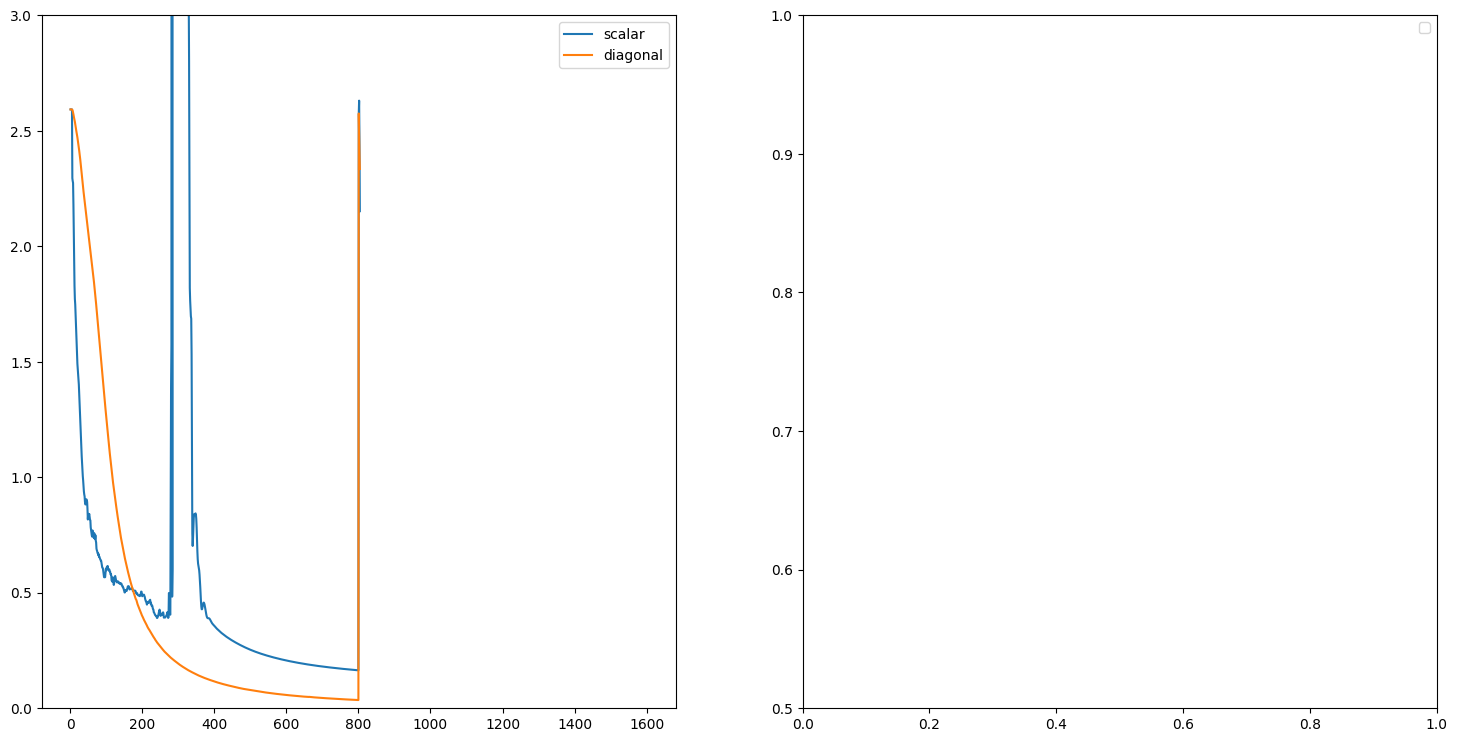

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from meta_opt.algoperf import runner
from meta_opt.experiment import ExperimentConfig
from meta_opt.optimizers import *
from meta_opt.optimizers.schedules import ConstantScheduleConfig

experiment_cfg = ExperimentConfig(
    seed = 0,
    full_batch = True,
    num_episodes = 3,
    num_iters = 800,
    batch_size = 256,
    eval_every = -1,

    workload_name = 'mnist',
    experiment_name = 'colab_test',
    experimental_setup = 'algoperf',
    data_dir = '../datasets',
    num_batch_devices=8, num_opt_devices=1,
)

cfgs = {
    # 'sgd': SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0.1)),
    # 'nesterov': SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0.01), nesterov=True, momentum=0.9),
    # 'adamw': AdamWConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0.001), b1=0.9, b2=0.999),
    # 'dadapt': DAdaptationConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1), b1=0.9, b2=0.999),
    # 'cocob': COCOBConfig(),
    # 'dog': DoGConfig(),
    # 'dowg': DoWGConfig(),
    # 'polyak': PolyakConfig(f_min=0),
    'scalar': MetaOptConfig(base_learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0.00), 
                             # scale_by_adam_betas=None, 
                             scale_by_adam_betas=(0.9, 0.999), 
                             H=1, HH=2, m_method='scalar', 
                             # meta_optimizer_cfg=SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-3), grad_clip=5),
                             meta_optimizer_cfg=SGDConfig(learning_rate_schedule_cfg=CosineScheduleConfig(init_value=0, warmup_steps=100, peak_value=1e-3, decay_steps=2000), grad_clip=None),
                             # meta_optimizer_cfg=COCOBConfig(),
                             # meta_optimizer_cfg=DAdaptationConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1), b1=0.9, b2=0.9),
                             # meta_optimizer_cfg=MechanicConfig(base_optimizer_cfg=SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-4))),
                             # meta_optimizer_cfg=AdamWConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-3), b1=0.9, b2=0.9),
                             counterfactual=True,
                             fake_the_dynamics=False, freeze_cost_fn_during_rollouts=False,
                             weight_decay=1e-4, grad_clip=None, freeze_gpc_params=None, use_bfloat16=False),
    'diagonal': MetaOptConfig(base_learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0.00), 
                         # scale_by_adam_betas=None, 
                         scale_by_adam_betas=(0.9, 0.999), 
                         H=1, HH=2, m_method='diagonal', 
                         # meta_optimizer_cfg=SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-3), grad_clip=None),
                         # meta_optimizer_cfg=SGDConfig(learning_rate_schedule_cfg=CosineScheduleConfig(init_value=0, warmup_steps=100, peak_value=1e-3, decay_steps=2000), grad_clip=None),
                         # meta_optimizer_cfg=SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-3), momentum=0.9, grad_clip=None),
                         # meta_optimizer_cfg=COCOBConfig(),
                         # meta_optimizer_cfg=DAdaptationConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=0.5), b1=0.9, b2=0.999),
                         # meta_optimizer_cfg=MechanicConfig(base_optimizer_cfg=SGDConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-1))),
                         # meta_optimizer_cfg=AdamWConfig(learning_rate_schedule_cfg=ConstantScheduleConfig(learning_rate=1e-3), b1=0.9, b2=0.9),
                         counterfactual=True,
                         fake_the_dynamics=False, freeze_cost_fn_during_rollouts=False,
                         weight_decay=1e-4, grad_clip=None, freeze_gpc_params=None, use_bfloat16=False),
}

from absl import flags
flags.FLAGS(['yeet.py', '--config_path', 'hi'])
fig, ax = plt.subplots(1, 2, figsize=(18, 9))
for cfg_key, cfg in cfgs.items():
    print('running', cfg_key)
    losses, evals, tstate = runner.run(experiment_cfg, cfg)
    ax[0].plot(losses.T[0], losses.T[1], label=cfg_key)
    if not experiment_cfg.full_batch: ax[1].plot(evals.T[0], evals.T[1], label=cfg_key)
    if cfg.optimizer_name == 'MetaOpt': print(tstate.opt_state[0].gpc_params)
ax[0].set_ylim(0, 3)
ax[1].set_ylim(0.5, 1)
ax[0].legend()
ax[1].legend()
# plt.savefig('../figs/mnist_synthetic.png')
